In [4]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import cv2
from  matplotlib.colors import LinearSegmentedColormap
from scipy.signal import butter, lfilter, iirnotch, filtfilt, resample, find_peaks, savgol_filter
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from scipy.io import savemat
from src.xray import *
from src.tdt_support import *
from src.filters import *
from src.neural_analysis import *
from src.cort_processing import *
from src.wiener_filter import *
from src.utils import *

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
tdt1 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/tdt/t0-030322-15-220303-161731'
kin1 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/angles/_t0-030322-15_2022-03-03_200f-11e100g1.csv'
toe1 = '/home/diya/Documents/rat-fes/data/DLC_anipose_models/anipose_t_march/session/pose-3d/_t0-030322-15_2022-03-03_200f-11e100g1.csv'
np_ts1 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/vids/TIMESTAMPS_cam1_t0-030322-15_2022-03-03_200f-11e100g1.npy'
crop1 = (5,180)

tdt2 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/tdt/t0-030322-15-2-220303-162513'
kin2 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/angles/_t0-030322-15-2_2022-03-03_200f-11e100g1.csv'
toe2 = '/home/diya/Documents/rat-fes/data/DLC_anipose_models/anipose_t_march/session/pose-3d/_t0-030322-15-2_2022-03-03_200f-11e100g1.csv'
np_ts2 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/vids/TIMESTAMPS_cam1_t0-030322-15-2_2022-03-03_200f-11e100g1.npy'
crop2 = (31,227)

tdt3 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/tdt/t0-030322-15-3-220303-163055'
kin3 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/angles/_t0-030322-15-3_2022-03-03_200f-11e100g1.csv'
toe3 = '/home/diya/Documents/rat-fes/data/DLC_anipose_models/anipose_t_march/session/pose-3d/_t0-030322-15-3_2022-03-03_200f-11e100g1.csv'
np_ts3 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/vids/TIMESTAMPS_cam1_t0-030322-15-3_2022-03-03_200f-11e100g1.npy'
crop3 = (5,200)

tdt4 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/tdt/t0-030322-15-4-220303-163556'
kin4 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/angles/_t0-030322-15-4_2022-03-03_200f-11e100g1.csv'
toe4 = '/home/diya/Documents/rat-fes/data/DLC_anipose_models/anipose_t_march/session/pose-3d/_t0-030322-15-4_2022-03-03_200f-11e100g1.csv'
np_ts4 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/vids/TIMESTAMPS_cam1_t0-030322-15-4_2022-03-03_200f-11e100g1.npy'
crop4 = (5,150)

In [6]:
rates1, angles1= process_neural_kinangles(tdt1, kin1, np_ts1, 3.0, crop1, binsize=0.05, toe_height_path = toe1)
rates2, angles2= process_neural_kinangles(tdt2, kin2, np_ts2, 3.0, crop2, binsize=0.05, toe_height_path = toe2)
rates3, angles3= process_neural_kinangles(tdt3, kin3, np_ts3, 3.0, crop3, binsize=0.05, toe_height_path = toe3)
rates4, angles4= process_neural_kinangles(tdt4, kin4, np_ts4, 3.0, crop4, binsize=0.05, toe_height_path = toe4)

#test_rates5, test_angles5 = process_neural_kinangles(tdt4, kin4, np_ts4, 3.0, test_crop, binsize=0.05)

rates_list = []
angles_list = []

rates_list.extend((rates1, rates2, rates3, rates4))
angles_list.extend((angles1, angles2, angles3, angles4))

TypeError: extract_tdt() missing 1 required positional argument: 'npts_file'

In [8]:
nada, full_angles1 = extract_anipose_angles(kin1)
full_angles1 = full_angles1[:, crop1[0]*200:crop1[1]*200]

nada, full_angles2 = extract_anipose_angles(kin2)
full_angles2 = full_angles2[:, crop2[0]*200:crop2[1]*200]

nada, full_angles3 = extract_anipose_angles(kin3)
full_angles3 = full_angles3[:, crop3[0]*200:crop3[1]*200]

nada, full_angles4 = extract_anipose_angles(kin4)
full_angles4 = full_angles4[:, crop4[0]*200:crop4[1]*200]

full_angles_list=[]
full_angles_list.extend((full_angles1, full_angles2, full_angles3, full_angles4))
uncut_kins = np.hstack(full_angles_list)

In [5]:
rates, kins = stitch_data(rates_list, angles_list)

In [11]:
forelimb_uncut = uncut_kins[-1,:]

h, vaf_array, test_x, test_y = decode_kfolds(rates, kins)
predic_kins = test_wiener_filter(test_x, h)
predic_forelimb = predic_kins[:,6]

In [30]:
peaks, nada = find_peaks(forelimb_uncut, prominence=10)
gait_list = []
for i in range(np.size(peaks)-1):
    end = peaks[i+1]
    start = peaks[i]
    gait = forelimb_uncut[start:end]
    gait_resample = resample(gait, 105)
    
    gait_list.append(gait_resample)
    
gaits = np.array(gait_list)
gait_avg = np.average(gaits, axis=0)
gait_std = np.std(gaits, axis=0)
phase_avg = np.sin(np.linspace(0.0, 2.0*math.pi, num=130,endpoint=False))
phase_avg = phase_avg[22:127]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
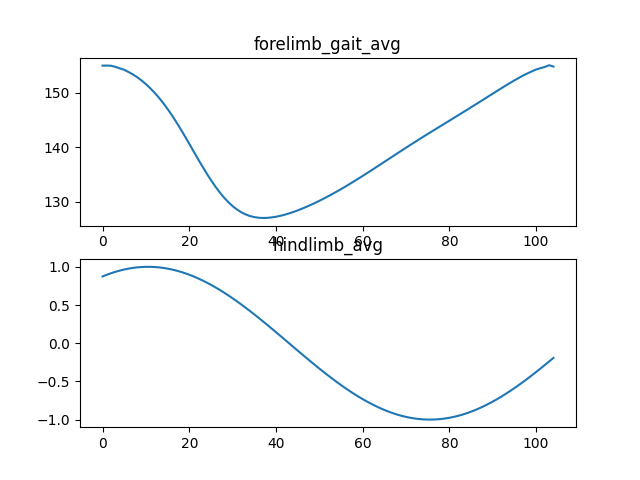

In [29]:
fig0=plt.figure()
ax0=fig0.add_subplot(211)
ax0.title.set_text('forelimb_gait_avg')
ax0.plot(gait_avg)
ax01 =fig0.add_subplot(212)
ax01.title.set_text('hindlimb_avg')
ax01.plot(phase_avg)

In [95]:
found_peak = -1
count=0

avg_peak = gait_avg[0]
avg_peak_std = gait_std[0]
output = []
start_window = 0
end_window = 10
window=slice(start_window, end_window)

for rate in test_x:
    count = count + 1
    rate = np.expand_dims(rate, axis=0)
    rt_predic_kin = test_wiener_filter(rate, h)
    rt_forelimb = rt_predic_kin[:,6]
    
    if found_peak == -1:
        #lets wait for a peak
        if rt_forelimb > avg_peak - (2*avg_peak_std):
            found_peak = 1
            idx = find_nearest(gait_avg[window], rt_forelimb)
            phase_avg_window = phase_avg[window]
            output.append(phase_avg_window[idx])
            start_window = start_window + 10
            end_window = end_window + 10
            window = slice(start_window, end_window)
        else:
            output.append(0)
            #print('bad')
        
    elif found_peak==1:
        idx = find_nearest(gait_avg[window], rt_forelimb)
        phase_avg_window = phase_avg[window]
        output.append(phase_avg_window[idx])
        start_window = start_window + 10
        end_window = end_window + 10
        window = slice(start_window, end_window)
        if start_window>60:
            found_peak = 0
                
    elif found_peak == 0:
        if rt_forelimb > avg_peak - (2*avg_peak_std):
            found_peak = 1
            idx = find_nearest(gait_avg[window], rt_forelimb)
            phase_avg_window = phase_avg[window]
            output.append(phase_avg_window[idx])
            start_window = 0
            end_window = 10
            window = slice(start_window, end_window)
        else:
            idx = find_nearest(gait_avg[window], rt_forelimb)
            phase_avg_window = phase_avg[window]
            output.append(phase_avg_window[idx])
            start_window = start_window + 10
            end_window = end_window + 10
            window = slice(start_window, end_window)
            if end_window > 100:
                start_window =0
                end_window = 10
                window = slice(start_window, end_window)
                found_peak = -1
                
   # print('found_peak:', found_peak)
    #print('index', start_window + idx)
    #print('predicted:', rt_forelimb)
    #print('closest', gait_avg[window][idx])
    #print('phase-predicted', output[-1])
            

In [104]:
limbfoot = test_y[:,3]
limbfoot_phase, nada = convert_to_phase(forelimb)

-0.11696492961805127


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
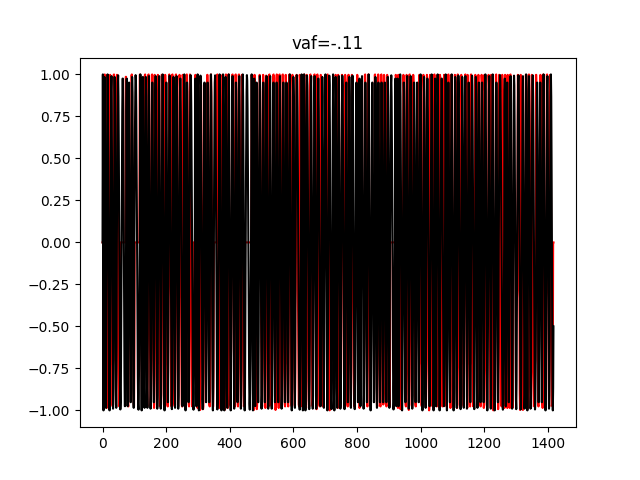

In [113]:
vaffy = vaf(limbfoot_phase, np.array(output))
print(vaffy)

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(output, c='red')
ax1.plot(limbfoot_phase, c='black')
ax1.title.set_text('vaf=-.11')

In [39]:
gait[window]

array([159.70415809, 159.68542011, 159.5682623 , 159.32451974,
       158.92418623, 158.33778132, 157.53875149, 156.50619399,
       155.22729215, 153.70073026])